In [27]:
import nest_asyncio
nest_asyncio.apply()

from hddCRP.simulations import simulate_sessions
from hddCRP.modelBuilder import cdCRP
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

In [28]:
N_blocks   = 20
N_sims_per_block = 50
simulation_range = [0,1]

block_range = range(1, N_sims_per_block+1)
run_range = range(0, N_blocks)

results_directory = "Results/Simulations/"
OVERWRITE = False;

if(not os.path.exists(results_directory)):
    os.makedirs(results_directory)

include_repeat_bias   = True;
context_depth = 1;

if(include_repeat_bias):
    nback_depth   = 1;
else:
    nback_depth   = 0;

In [29]:
for simulation_id in simulation_range:

    if(simulation_id == 0):
        alpha = 5
        different_context_weights = [0.2, 0.2];
        within_session_timescales  = {"A" : 20}
        between_session_timescales = None; #{("A","A") : 2}
        repeat_bias_1_back = 0.5

        session_labels  = lambda n_blocks : ["A"] ;
        session_lengths = lambda n_blocks : [25 * n_blocks ];
        num_subjects = lambda n_blocks : 1;
        num_responses = 3
        simulation_name = "sim. 1"
    elif(simulation_id == 1):
        alpha = 3
        different_context_weights = [0.8, 0.8];
        within_session_timescales  = {"A" : 50}
        between_session_timescales = None; #{("A","A") : 2}
        repeat_bias_1_back = 1.0

        session_labels  = lambda n_blocks : ["A"] ;
        session_lengths = lambda n_blocks : [25 * n_blocks ];
        num_subjects = lambda n_blocks :  1;
        num_responses = 3
        simulation_name = "sim. 2"
    else:
        raise NotImplementedError("No sim found")
    
    if(not nback_depth):
        repeat_bias_1_back = None;
    different_context_weights = different_context_weights[:context_depth]
    
    fit_file = f"{results_directory}/simulation_{simulation_id}"
    fit_summary_file = f"{results_directory}/simulation_summary_{simulation_id}"
    fit_file += f"_cd{context_depth}_nb{nback_depth}"
    fit_summary_file  += f"_cd{context_depth}_nb{nback_depth}"
    fit_file += f".pkl"
    fit_summary_file  += f".pkl"

        
    if(((not os.path.isfile(fit_file)) or (not os.path.isfile(fit_summary_file))) or OVERWRITE):
        simulation_fits = pd.DataFrame()
        simulation_fit_metrics = pd.DataFrame()
    else:
        simulation_fits = pd.read_pickle(fit_file)
        simulation_fit_metrics = pd.read_pickle(fit_summary_file)

    for block_idx in block_range:
        print(f"BLOCK {block_idx}")

        
        for run_idx in run_range:
            if(not ("simulation_id" in simulation_fit_metrics) or not ("block" in simulation_fit_metrics) or not ("run" in simulation_fit_metrics) or
                simulation_fit_metrics.query("simulation_id == @simulation_id and block == @block_idx and run == @run_idx").size == 0):
                print(f"BLOCK {block_idx} - RUN {run_idx}")
                sim_seed  = (simulation_id+8) * 10000 + nback_depth * 1001 + context_depth * 1000 + run_idx*100 
                stan_seed = (simulation_id+8) * 10000 + nback_depth * 1001 + context_depth * 1000 + run_idx*100 + block_idx
                
                seqs = [];
                subject_labels = [];
                session_labels_all = [];
                for jj in range(num_subjects(block_idx)):
                    sim_rng = np.random.Generator(np.random.MT19937(sim_seed + jj))
                    seqs_c = simulate_sessions(session_lengths=session_lengths(block_idx), session_labels=session_labels(block_idx), num_responses=num_responses, 
                                            alpha=alpha,
                                            different_context_weights=different_context_weights,
                                            within_session_timescales=within_session_timescales, between_session_timescales=between_session_timescales,
                                            repeat_bias_1_back=repeat_bias_1_back, rng=sim_rng)
                    subject_labels += [jj] * len(seqs_c)
                    session_labels_all += session_labels(block_idx)
                    seqs += seqs_c;

                model = cdCRP(seqs, subject_labels=subject_labels, session_labels=session_labels_all);
                model.same_nback_depth = nback_depth;
                model.context_depth = context_depth;
                
                model.context_depth = len(different_context_weights)
                model.build(random_seed=stan_seed);
                model.fit_model()

                fit_df = model.fit.to_frame()
                fit_df["block"] = block_idx
                fit_df["run"]   = run_idx
                fit_df["simulation_id"]   = simulation_id
                summary_df = model.fit_summary()
                summary_df["block"] = block_idx
                summary_df["run"]   = run_idx
                summary_df["simulation_id"]   = simulation_id
                summary_df["trials"]   = model.session_lengths.sum()
                summary_df["sessions"]   = model.num_sessions
                summary_df["n_subjects"]   = model.num_subjects
                summary_df["simulation"]   = simulation_name
                #map_fit = model.get_map()
                #summary_df["MAP"] = pd.Series(map_fit)

                true_param = {"alpha" : alpha,
                "timeconstant_within_session_A" : within_session_timescales["A"]}
                if(nback_depth >= 1):
                    true_param["repeat_bias_1_back"] = repeat_bias_1_back
                if(nback_depth >= 1):
                    true_param["context_similarity_depth_1"] = different_context_weights[0]
                if(nback_depth >= 21):
                    true_param["context_similarity_depth_2"] = different_context_weights[1]

                summary_df["true"] = pd.Series(true_param)
                

                simulation_fit_metrics = pd.concat([simulation_fit_metrics,summary_df], copy=False)
                simulation_fits = pd.concat([simulation_fits,fit_df], copy=False)

                simulation_fits.to_pickle(fit_file)
                simulation_fit_metrics.to_pickle(fit_summary_file)
            else:
                print("Fit files found: not overriding")

BLOCK 1
BLOCK 1 - RUN 0
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 2
t 2: [0.29962101 0.29962101 0.40075798], [2.         2.         2.67509936], 2
t 3: [0.2650891  0.2650891  0.46982181], [2.         2.         3.54463322], 2
t 4: [0.23889841 0.23889841 0.52220318], [2.         2.         4.37175942], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   1% (100/8000)
Sampling:   4% (300/8000)
Sampling:   8% (600/8000)
Sampling:  12% (1000/8000)
Sampling:  36% (2900/8000)
Sampling:  59% (4700/8000)
Sampling:  80% (6400/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000364 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.64 seconds.
  Adjust your expectations accordi

BLOCK 1 - RUN 1
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 1
t 2: [0.30841098 0.27155333 0.42003569], [2.         1.76098354 2.72386993], 0
t 3: [0.24548731 0.37971707 0.37479563], [1.76098354 2.72386993 2.68856638], 1
t 4: [0.3626798  0.30583546 0.33148474], [2.90483742 2.44954992 2.6549846 ], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   1% (100/8000)
Sampling:   4% (300/8000)
Sampling:   8% (600/8000)
Sampling:  11% (900/8000)
Sampling:  35% (2800/8000)
Sampling:  58% (4600/8000)
Sampling:  79% (6300/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000371 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.71 seconds.
  Adjust your expectations accordin

BLOCK 1 - RUN 2
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 0
t 2: [0.27155333 0.30841098 0.42003569], [1.76098354 2.         2.72386993], 1
t 3: [0.37971707 0.24548731 0.37479563], [2.72386993 1.76098354 2.68856638], 0
t 4: [0.30583546 0.3626798  0.33148474], [2.44954992 2.90483742 2.6549846 ], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   1% (100/8000)
Sampling:   4% (300/8000)
Sampling:   6% (500/8000)
Sampling:  11% (900/8000)
Sampling:  35% (2800/8000)
Sampling:  58% (4600/8000)
Sampling:  80% (6400/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000363 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.63 seconds.
  Adjust your expectations accordin

BLOCK 1 - RUN 3
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 2
t 2: [0.29962101 0.29962101 0.40075798], [2.         2.         2.67509936], 2
t 3: [0.2650891  0.2650891  0.46982181], [2.         2.         3.54463322], 0
t 4: [0.22494795 0.2554799  0.51957215], [1.76098354 2.         4.06742092], 1
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   1% (100/8000)
Sampling:   5% (400/8000)
Sampling:  10% (800/8000)
Sampling:  15% (1200/8000)
Sampling:  39% (3100/8000)
Sampling:  60% (4800/8000)
Sampling:  80% (6400/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000622 seconds
  1000 transitions using 10 leapfrog steps per transition would take 6.22 seconds.
  Adjust your expectations accordi

BLOCK 1 - RUN 4
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 0
t 2: [0.27155333 0.30841098 0.42003569], [1.76098354 2.         2.72386993], 2
t 3: [0.3949802  0.27194651 0.33307328], [2.90483742 2.         2.44954992], 0
t 4: [0.30583546 0.24970747 0.44445707], [2.44954992 2.         3.55982202], 1
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   2% (200/8000)
Sampling:   6% (500/8000)
Sampling:  11% (900/8000)
Sampling:  16% (1300/8000)
Sampling:  39% (3100/8000)
Sampling:  60% (4800/8000)
Sampling:  80% (6400/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000441 seconds
  1000 transitions using 10 leapfrog steps per transition would take 4.41 seconds.
  Adjust your expectations accordi

BLOCK 1 - RUN 5
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 1
repeat_bias_1_back = 0.5
	base measure[0.4 0.2 0.4]
t 1: [0.34716294 0.30567411 0.34716294], [2.         1.76098354 2.        ], 0
t 2: [0.27155333 0.42003569 0.30841098], [1.76098354 2.72386993 2.        ], 0
t 3: [0.36328365 0.3651125  0.27160385], [2.67509936 2.68856638 2.        ], 2
t 4: [0.43590445 0.3391476  0.22494795], [3.41243632 2.6549846  1.76098354], 1
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   2% (200/8000)
Sampling:   6% (500/8000)
Sampling:  10% (800/8000)
Sampling:  15% (1200/8000)
Sampling:  38% (3000/8000)
Sampling:  59% (4700/8000)
Sampling:  80% (6400/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000374 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.74 seconds.
  Adjust your expectations accordi

BLOCK 1 - RUN 6
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 0
repeat_bias_1_back = 0.5
	base measure[0.2 0.4 0.4]
t 1: [0.30567411 0.34716294 0.34716294], [1.76098354 2.         2.        ], 0
t 2: [0.40075798 0.29962101 0.29962101], [2.67509936 2.         2.        ], 1
t 3: [0.47570564 0.24548731 0.27880705], [3.41243632 1.76098354 2.        ], 0
t 4: [0.40049755 0.3550489  0.24445355], [3.27667612 2.90483742 2.        ], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   1% (100/8000)
Sampling:   5% (400/8000)
Sampling:   9% (700/8000)
Sampling:  15% (1200/8000)
Sampling:  39% (3100/8000)
Sampling:  60% (4800/8000)
Sampling:  81% (6500/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.00044 seconds
  1000 transitions using 10 leapfrog steps per transition would take 4.4 seconds.
  Adjust your expectations according

BLOCK 1 - RUN 7
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 2
t 2: [0.29962101 0.29962101 0.40075798], [2.         2.         2.67509936], 0
t 3: [0.24548731 0.27880705 0.47570564], [1.76098354 2.         3.41243632], 2
t 4: [0.3550489  0.24445355 0.40049755], [2.90483742 2.         3.27667612], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   2% (200/8000)
Sampling:   6% (500/8000)
Sampling:  11% (900/8000)
Sampling:  18% (1400/8000)
Sampling:  40% (3200/8000)
Sampling:  61% (4900/8000)
Sampling:  81% (6500/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000368 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.68 seconds.
  Adjust your expectations accordi

BLOCK 1 - RUN 8
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 1
repeat_bias_1_back = 0.5
	base measure[0.4 0.2 0.4]
t 1: [0.34716294 0.30567411 0.34716294], [2.         1.76098354 2.        ], 0
t 2: [0.27155333 0.42003569 0.30841098], [1.76098354 2.72386993 2.        ], 1
t 3: [0.3949802  0.33307328 0.27194651], [2.90483742 2.44954992 2.        ], 1
t 4: [0.34925902 0.40656435 0.24417663], [2.86070798 3.33008396 2.        ], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   2% (200/8000)
Sampling:   6% (500/8000)
Sampling:  10% (800/8000)
Sampling:  15% (1200/8000)
Sampling:  38% (3000/8000)
Sampling:  59% (4700/8000)
Sampling:  80% (6400/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000298 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.98 seconds.
  Adjust your expectations accordi

BLOCK 1 - RUN 9
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 1
repeat_bias_1_back = 0.5
	base measure[0.4 0.2 0.4]
t 1: [0.34716294 0.30567411 0.34716294], [2.         1.76098354 2.        ], 2
t 2: [0.30841098 0.42003569 0.27155333], [2.         2.72386993 1.76098354], 0
t 3: [0.24548731 0.37479563 0.37971707], [1.76098354 2.68856638 2.72386993], 1
t 4: [0.3404605  0.30197541 0.35756409], [2.72386993 2.41596814 2.86070798], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   2% (200/8000)
Sampling:   6% (500/8000)
Sampling:  10% (800/8000)
Sampling:  16% (1300/8000)
Sampling:  39% (3100/8000)
Sampling:  60% (4800/8000)
Sampling:  81% (6500/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000318 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.18 seconds.
  Adjust your expectations accordi

BLOCK 1 - RUN 10
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 0
repeat_bias_1_back = 0.5
	base measure[0.2 0.4 0.4]
t 1: [0.30567411 0.34716294 0.34716294], [1.76098354 2.         2.        ], 2
t 2: [0.42003569 0.30841098 0.27155333], [2.72386993 2.         1.76098354], 0
t 3: [0.33307328 0.27194651 0.3949802 ], [2.44954992 2.         2.90483742], 2
t 4: [0.44445707 0.24970747 0.30583546], [3.55982202 2.         2.44954992], 0
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   2% (200/8000)
Sampling:   6% (500/8000)
Sampling:  11% (900/8000)
Sampling:  18% (1400/8000)
Sampling:  40% (3200/8000)
Sampling:  61% (4900/8000)
Sampling:  81% (6500/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000296 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.96 seconds.
  Adjust your expectations accordi

BLOCK 1 - RUN 11
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 1
t 2: [0.30841098 0.27155333 0.42003569], [2.         1.76098354 2.72386993], 2
t 3: [0.27194651 0.3949802  0.33307328], [2.         2.90483742 2.44954992], 1
t 4: [0.24970747 0.30583546 0.44445707], [2.         2.44954992 3.55982202], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   1% (100/8000)
Sampling:   4% (300/8000)
Sampling:   8% (600/8000)
Sampling:  12% (1000/8000)
Sampling:  36% (2900/8000)
Sampling:  59% (4700/8000)
Sampling:  80% (6400/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000296 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.96 seconds.
  Adjust your expectations accordi

BLOCK 1 - RUN 12
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 1
t 2: [0.30841098 0.27155333 0.42003569], [2.         1.76098354 2.72386993], 1
t 3: [0.27160385 0.36328365 0.3651125 ], [2.         2.67509936 2.68856638], 0
t 4: [0.22494795 0.43590445 0.3391476 ], [1.76098354 3.41243632 2.6549846 ], 1
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   2% (200/8000)
Sampling:   6% (500/8000)
Sampling:  11% (900/8000)
Sampling:  16% (1300/8000)
Sampling:  39% (3100/8000)
Sampling:  60% (4800/8000)
Sampling:  80% (6400/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000642 seconds
  1000 transitions using 10 leapfrog steps per transition would take 6.42 seconds.
  Adjust your expectations accordi

BLOCK 1 - RUN 13
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 0
repeat_bias_1_back = 0.5
	base measure[0.2 0.4 0.4]
t 1: [0.30567411 0.34716294 0.34716294], [1.76098354 2.         2.        ], 2
t 2: [0.42003569 0.30841098 0.27155333], [2.72386993 2.         1.76098354], 0
t 3: [0.33307328 0.27194651 0.3949802 ], [2.44954992 2.         2.90483742], 1
t 4: [0.43161471 0.22494795 0.34343734], [3.37885454 1.76098354 2.68856638], 0
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   1% (100/8000)
Sampling:   5% (400/8000)
Sampling:  10% (800/8000)
Sampling:  15% (1200/8000)
Sampling:  39% (3100/8000)
Sampling:  60% (4800/8000)
Sampling:  80% (6400/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000309 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.09 seconds.
  Adjust your expectations accordi

BLOCK 1 - RUN 14
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 0
repeat_bias_1_back = 0.5
	base measure[0.2 0.4 0.4]
t 1: [0.30567411 0.34716294 0.34716294], [1.76098354 2.         2.        ], 1
t 2: [0.42003569 0.27155333 0.30841098], [2.72386993 1.76098354 2.        ], 1
t 3: [0.3651125  0.36328365 0.27160385], [2.68856638 2.67509936 2.        ], 2
t 4: [0.3391476  0.43590445 0.22494795], [2.6549846  3.41243632 1.76098354], 1
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   2% (200/8000)
Sampling:   6% (500/8000)
Sampling:  11% (900/8000)
Sampling:  16% (1300/8000)
Sampling:  39% (3100/8000)
Sampling:  60% (4800/8000)
Sampling:  80% (6400/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000297 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.97 seconds.
  Adjust your expectations accordi

BLOCK 1 - RUN 15
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 1
repeat_bias_1_back = 0.5
	base measure[0.4 0.2 0.4]
t 1: [0.34716294 0.30567411 0.34716294], [2.         1.76098354 2.        ], 1
t 2: [0.29962101 0.40075798 0.29962101], [2.         2.67509936 2.        ], 2
t 3: [0.27880705 0.47570564 0.24548731], [2.         3.41243632 1.76098354], 1
t 4: [0.24445355 0.40049755 0.3550489 ], [2.         3.27667612 2.90483742], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   1% (100/8000)
Sampling:   5% (400/8000)
Sampling:   9% (700/8000)
Sampling:  15% (1200/8000)
Sampling:  39% (3100/8000)
Sampling:  60% (4800/8000)
Sampling:  81% (6500/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000317 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.17 seconds.
  Adjust your expectations accordi

BLOCK 1 - RUN 16
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 1
t 2: [0.30841098 0.27155333 0.42003569], [2.         1.76098354 2.72386993], 0
t 3: [0.24548731 0.37971707 0.37479563], [1.76098354 2.72386993 2.68856638], 1
t 4: [0.3626798  0.30583546 0.33148474], [2.90483742 2.44954992 2.6549846 ], 1
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   2% (200/8000)
Sampling:   6% (500/8000)
Sampling:  11% (900/8000)
Sampling:  18% (1400/8000)
Sampling:  40% (3200/8000)
Sampling:  61% (4900/8000)
Sampling:  81% (6500/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000299 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.99 seconds.
  Adjust your expectations accordi

BLOCK 1 - RUN 17
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 0
repeat_bias_1_back = 0.5
	base measure[0.2 0.4 0.4]
t 1: [0.30567411 0.34716294 0.34716294], [1.76098354 2.         2.        ], 1
t 2: [0.42003569 0.27155333 0.30841098], [2.72386993 1.76098354 2.        ], 0
t 3: [0.33307328 0.3949802  0.27194651], [2.44954992 2.90483742 2.        ], 2
t 4: [0.43161471 0.34343734 0.22494795], [3.37885454 2.68856638 1.76098354], 1
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   2% (200/8000)
Sampling:   6% (500/8000)
Sampling:  10% (800/8000)
Sampling:  14% (1100/8000)
Sampling:  36% (2900/8000)
Sampling:  58% (4600/8000)
Sampling:  79% (6300/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000296 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.96 seconds.
  Adjust your expectations accordi

BLOCK 1 - RUN 18
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 0
repeat_bias_1_back = 0.5
	base measure[0.2 0.4 0.4]
t 1: [0.30567411 0.34716294 0.34716294], [1.76098354 2.         2.        ], 1
t 2: [0.42003569 0.27155333 0.30841098], [2.72386993 1.76098354 2.        ], 0
t 3: [0.33307328 0.3949802  0.27194651], [2.44954992 2.90483742 2.        ], 0
t 4: [0.40656435 0.34925902 0.24417663], [3.33008396 2.86070798 2.        ], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   2% (200/8000)
Sampling:   6% (500/8000)
Sampling:  11% (900/8000)
Sampling:  18% (1400/8000)
Sampling:  40% (3200/8000)
Sampling:  61% (4900/8000)
Sampling:  81% (6500/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000298 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.98 seconds.
  Adjust your expectations accordi

BLOCK 1 - RUN 19
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 0
repeat_bias_1_back = 0.5
	base measure[0.2 0.4 0.4]
t 1: [0.30567411 0.34716294 0.34716294], [1.76098354 2.         2.        ], 2
t 2: [0.42003569 0.30841098 0.27155333], [2.72386993 2.         1.76098354], 1
t 3: [0.37479563 0.24548731 0.37971707], [2.68856638 1.76098354 2.72386993], 0
t 4: [0.30197541 0.3404605  0.35756409], [2.41596814 2.72386993 2.86070798], 1
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   2% (200/8000)
Sampling:   8% (600/8000)
Sampling:  12% (1000/8000)
Sampling:  18% (1400/8000)
Sampling:  40% (3200/8000)
Sampling:  60% (4800/8000)
Sampling:  80% (6400/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000296 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.96 seconds.
  Adjust your expectations accord

BLOCK 1 - RUN 20
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 0
repeat_bias_1_back = 0.5
	base measure[0.2 0.4 0.4]
t 1: [0.30567411 0.34716294 0.34716294], [1.76098354 2.         2.        ], 1
t 2: [0.42003569 0.27155333 0.30841098], [2.72386993 1.76098354 2.        ], 1
t 3: [0.3651125  0.36328365 0.27160385], [2.68856638 2.67509936 2.        ], 0
t 4: [0.30197541 0.44804166 0.24998294], [2.41596814 3.58457791 2.        ], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   1% (100/8000)
Sampling:   5% (400/8000)
Sampling:  10% (800/8000)
Sampling:  16% (1300/8000)
Sampling:  40% (3200/8000)
Sampling:  61% (4900/8000)
Sampling:  81% (6500/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000325 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.25 seconds.
  Adjust your expectations accordi

BLOCK 1 - RUN 21
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 0
repeat_bias_1_back = 0.5
	base measure[0.2 0.4 0.4]
t 1: [0.30567411 0.34716294 0.34716294], [1.76098354 2.         2.        ], 1
t 2: [0.42003569 0.27155333 0.30841098], [2.72386993 1.76098354 2.        ], 0
t 3: [0.33307328 0.3949802  0.27194651], [2.44954992 2.90483742 2.        ], 0
t 4: [0.40656435 0.34925902 0.24417663], [3.33008396 2.86070798 2.        ], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   2% (200/8000)
Sampling:   6% (500/8000)
Sampling:  10% (800/8000)
Sampling:  15% (1200/8000)
Sampling:  38% (3000/8000)
Sampling:  59% (4700/8000)
Sampling:  80% (6400/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.00033 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.3 seconds.
  Adjust your expectations according

BLOCK 1 - RUN 22
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 0
repeat_bias_1_back = 0.5
	base measure[0.2 0.4 0.4]
t 1: [0.30567411 0.34716294 0.34716294], [1.76098354 2.         2.        ], 0
t 2: [0.40075798 0.29962101 0.29962101], [2.67509936 2.         2.        ], 0
t 3: [0.46982181 0.2650891  0.2650891 ], [3.54463322 2.         2.        ], 0
t 4: [0.52220318 0.23889841 0.23889841], [4.37175942 2.         2.        ], 0
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   4% (300/8000)
Sampling:   9% (700/8000)
Sampling:  14% (1100/8000)
Sampling:  20% (1600/8000)
Sampling:  41% (3300/8000)
Sampling:  61% (4900/8000)
Sampling:  81% (6500/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000621 seconds
  1000 transitions using 10 leapfrog steps per transition would take 6.21 seconds.
  Adjust your expectations accord

BLOCK 1 - RUN 23
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 2
t 2: [0.29962101 0.29962101 0.40075798], [2.         2.         2.67509936], 2
t 3: [0.2650891  0.2650891  0.46982181], [2.         2.         3.54463322], 1
t 4: [0.2554799  0.22494795 0.51957215], [2.         1.76098354 4.06742092], 0
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   2% (200/8000)
Sampling:   6% (500/8000)
Sampling:  11% (900/8000)
Sampling:  18% (1400/8000)
Sampling:  40% (3200/8000)
Sampling:  61% (4900/8000)
Sampling:  81% (6500/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000302 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.02 seconds.
  Adjust your expectations accordi

BLOCK 1 - RUN 24
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 2
t 2: [0.29962101 0.29962101 0.40075798], [2.         2.         2.67509936], 2
t 3: [0.2650891  0.2650891  0.46982181], [2.         2.         3.54463322], 2
t 4: [0.23889841 0.23889841 0.52220318], [2.         2.         4.37175942], 0
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   2% (200/8000)
Sampling:   5% (400/8000)
Sampling:   8% (600/8000)
Sampling:  12% (1000/8000)
Sampling:  35% (2800/8000)
Sampling:  58% (4600/8000)
Sampling:  80% (6400/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000303 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.03 seconds.
  Adjust your expectations accordi

BLOCK 1 - RUN 25
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 0
t 2: [0.27155333 0.30841098 0.42003569], [1.76098354 2.         2.72386993], 2
t 3: [0.3949802  0.27194651 0.33307328], [2.90483742 2.         2.44954992], 2
t 4: [0.34925902 0.24417663 0.40656435], [2.86070798 2.         3.33008396], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   1% (100/8000)
Sampling:   4% (300/8000)
Sampling:   8% (600/8000)
Sampling:  12% (1000/8000)
Sampling:  36% (2900/8000)
Sampling:  59% (4700/8000)
Sampling:  80% (6400/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000305 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.05 seconds.
  Adjust your expectations accordi

BLOCK 1 - RUN 26
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 0
repeat_bias_1_back = 0.5
	base measure[0.2 0.4 0.4]
t 1: [0.30567411 0.34716294 0.34716294], [1.76098354 2.         2.        ], 2
t 2: [0.42003569 0.30841098 0.27155333], [2.72386993 2.         1.76098354], 2
t 3: [0.3651125  0.27160385 0.36328365], [2.68856638 2.         2.67509936], 2
t 4: [0.3237937  0.24391381 0.43229249], [2.6549846  2.         3.54463322], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   2% (200/8000)
Sampling:   6% (500/8000)
Sampling:  11% (900/8000)
Sampling:  15% (1200/8000)
Sampling:  38% (3000/8000)
Sampling:  59% (4700/8000)
Sampling:  79% (6300/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000299 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.99 seconds.
  Adjust your expectations accordi

BLOCK 1 - RUN 27
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 1
repeat_bias_1_back = 0.5
	base measure[0.4 0.2 0.4]
t 1: [0.34716294 0.30567411 0.34716294], [2.         1.76098354 2.        ], 0
t 2: [0.27155333 0.42003569 0.30841098], [1.76098354 2.72386993 2.        ], 1
t 3: [0.3949802  0.33307328 0.27194651], [2.90483742 2.44954992 2.        ], 0
t 4: [0.30583546 0.44445707 0.24970747], [2.44954992 3.55982202 2.        ], 1
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   2% (200/8000)
Sampling:   5% (400/8000)
Sampling:  10% (800/8000)
Sampling:  16% (1300/8000)
Sampling:  39% (3100/8000)
Sampling:  61% (4900/8000)
Sampling:  81% (6500/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000292 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.92 seconds.
  Adjust your expectations accordi

BLOCK 1 - RUN 28
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 1
repeat_bias_1_back = 0.5
	base measure[0.4 0.2 0.4]
t 1: [0.34716294 0.30567411 0.34716294], [2.         1.76098354 2.        ], 0
t 2: [0.27155333 0.42003569 0.30841098], [1.76098354 2.72386993 2.        ], 1
t 3: [0.3949802  0.33307328 0.27194651], [2.90483742 2.44954992 2.        ], 2
t 4: [0.34343734 0.43161471 0.22494795], [2.68856638 3.37885454 1.76098354], 1
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   2% (200/8000)
Sampling:   6% (500/8000)
Sampling:  10% (800/8000)
Sampling:  15% (1200/8000)
Sampling:  38% (3000/8000)
Sampling:  59% (4700/8000)
Sampling:  80% (6400/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000296 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.96 seconds.
  Adjust your expectations accordi

BLOCK 1 - RUN 29
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 1
t 2: [0.30841098 0.27155333 0.42003569], [2.         1.76098354 2.72386993], 2
t 3: [0.27194651 0.3949802  0.33307328], [2.         2.90483742 2.44954992], 0
t 4: [0.22494795 0.34343734 0.43161471], [1.76098354 2.68856638 3.37885454], 0
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   1% (100/8000)
Sampling:   4% (300/8000)
Sampling:   6% (500/8000)
Sampling:  11% (900/8000)
Sampling:  35% (2800/8000)
Sampling:  58% (4600/8000)
Sampling:  80% (6400/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000299 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.99 seconds.
  Adjust your expectations accordin

BLOCK 1 - RUN 30
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 1
repeat_bias_1_back = 0.5
	base measure[0.4 0.2 0.4]
t 1: [0.34716294 0.30567411 0.34716294], [2.         1.76098354 2.        ], 2
t 2: [0.30841098 0.42003569 0.27155333], [2.         2.72386993 1.76098354], 2
t 3: [0.27160385 0.3651125  0.36328365], [2.         2.68856638 2.67509936], 0
t 4: [0.22494795 0.3391476  0.43590445], [1.76098354 2.6549846  3.41243632], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   1% (100/8000)
Sampling:   5% (400/8000)
Sampling:  10% (800/8000)
Sampling:  15% (1200/8000)
Sampling:  39% (3100/8000)
Sampling:  60% (4800/8000)
Sampling:  80% (6400/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000301 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.01 seconds.
  Adjust your expectations accordi

BLOCK 1 - RUN 31
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 0
t 2: [0.27155333 0.30841098 0.42003569], [1.76098354 2.         2.72386993], 1
t 3: [0.37971707 0.24548731 0.37479563], [2.72386993 1.76098354 2.68856638], 1
t 4: [0.33528914 0.33360968 0.33110118], [2.68856638 2.67509936 2.6549846 ], 1
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000843 seconds
  1000 transitions using 10 leapfrog steps per transition would take 8.43 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/tmp/httpstan_l2qseuaj/

BLOCK 1 - RUN 32
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 1
repeat_bias_1_back = 0.5
	base measure[0.4 0.2 0.4]
t 1: [0.34716294 0.30567411 0.34716294], [2.         1.76098354 2.        ], 2
t 2: [0.30841098 0.42003569 0.27155333], [2.         2.72386993 1.76098354], 1
t 3: [0.27194651 0.33307328 0.3949802 ], [2.         2.44954992 2.90483742], 1
t 4: [0.24417663 0.40656435 0.34925902], [2.         3.33008396 2.86070798], 1
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000867 seconds
  1000 transitions using 10 leapfrog steps per transition would take 8.67 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000886 seconds
  1000 transitions using 10 leapfrog steps per transition would take 8.86 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis prop

BLOCK 1 - RUN 33
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 1
repeat_bias_1_back = 0.5
	base measure[0.4 0.2 0.4]
t 1: [0.34716294 0.30567411 0.34716294], [2.         1.76098354 2.        ], 1
t 2: [0.29962101 0.40075798 0.29962101], [2.         2.67509936 2.        ], 1
t 3: [0.2650891  0.46982181 0.2650891 ], [2.         3.54463322 2.        ], 1
t 4: [0.23889841 0.52220318 0.23889841], [2.         4.37175942 2.        ], 1
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000481 seconds
  1000 transitions using 10 leapfrog steps per transition would take 4.81 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/tmp/httpstan_l2qseuaj/mo

BLOCK 1 - RUN 34
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 1
repeat_bias_1_back = 0.5
	base measure[0.4 0.2 0.4]
t 1: [0.34716294 0.30567411 0.34716294], [2.         1.76098354 2.        ], 0
t 2: [0.27155333 0.42003569 0.30841098], [1.76098354 2.72386993 2.        ], 1
t 3: [0.3949802  0.33307328 0.27194651], [2.90483742 2.44954992 2.        ], 1
t 4: [0.34925902 0.40656435 0.24417663], [2.86070798 3.33008396 2.        ], 0
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.00033 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.3 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00086 seconds
  1000 transitions using 10 leapfrog steps per transition would take 8.6 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal

BLOCK 1 - RUN 35
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 1
repeat_bias_1_back = 0.5
	base measure[0.4 0.2 0.4]
t 1: [0.34716294 0.30567411 0.34716294], [2.         1.76098354 2.        ], 0
t 2: [0.27155333 0.42003569 0.30841098], [1.76098354 2.72386993 2.        ], 2
t 3: [0.37971707 0.37479563 0.24548731], [2.72386993 2.68856638 1.76098354], 2
t 4: [0.33528914 0.33110118 0.33360968], [2.68856638 2.6549846  2.67509936], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000878 seconds
  1000 transitions using 10 leapfrog steps per transition would take 8.78 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000895 seconds
  1000 transitions using 10 leapfrog steps per transition would take 8.95 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000852 seconds
  1000 t

BLOCK 1 - RUN 36
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 0
repeat_bias_1_back = 0.5
	base measure[0.2 0.4 0.4]
t 1: [0.30567411 0.34716294 0.34716294], [1.76098354 2.         2.        ], 0
t 2: [0.40075798 0.29962101 0.29962101], [2.67509936 2.         2.        ], 1
t 3: [0.47570564 0.24548731 0.27880705], [3.41243632 1.76098354 2.        ], 2
t 4: [0.42710504 0.34794701 0.22494795], [3.34355098 2.72386993 1.76098354], 0
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000872 seconds
  1000 transitions using 10 leapfrog steps per transition would take 8.72 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: bernoulli_lpmf: Probability parameter[1] is -nan, but must be in the interval [0, 1] (in '/tm

BLOCK 1 - RUN 37
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 0
repeat_bias_1_back = 0.5
	base measure[0.2 0.4 0.4]
t 1: [0.30567411 0.34716294 0.34716294], [1.76098354 2.         2.        ], 2
t 2: [0.42003569 0.30841098 0.27155333], [2.72386993 2.         1.76098354], 2
t 3: [0.3651125  0.27160385 0.36328365], [2.68856638 2.         2.67509936], 2
t 4: [0.3237937  0.24391381 0.43229249], [2.6549846  2.         3.54463322], 0
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000844 seconds
  1000 transitions using 10 leapfrog steps per transition would take 8.44 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: bernoulli_lpmf: Probability parameter[1] is -nan, but must be in the interval [0, 1] (in '/tm

BLOCK 1 - RUN 38
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 0
repeat_bias_1_back = 0.5
	base measure[0.2 0.4 0.4]
t 1: [0.30567411 0.34716294 0.34716294], [1.76098354 2.         2.        ], 1
t 2: [0.42003569 0.27155333 0.30841098], [2.72386993 1.76098354 2.        ], 0
t 3: [0.33307328 0.3949802  0.27194651], [2.44954992 2.90483742 2.        ], 1
t 4: [0.44445707 0.30583546 0.24970747], [3.55982202 2.44954992 2.        ], 1
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000862 seconds
  1000 transitions using 10 leapfrog steps per transition would take 8.62 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/tmp/httpstan_l2qseuaj/

BLOCK 1 - RUN 39
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 0
repeat_bias_1_back = 0.5
	base measure[0.2 0.4 0.4]
t 1: [0.30567411 0.34716294 0.34716294], [1.76098354 2.         2.        ], 2
t 2: [0.42003569 0.30841098 0.27155333], [2.72386993 2.         1.76098354], 1
t 3: [0.37479563 0.24548731 0.37971707], [2.68856638 1.76098354 2.72386993], 0
t 4: [0.30197541 0.3404605  0.35756409], [2.41596814 2.72386993 2.86070798], 1
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000307 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.07 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: bernoulli_lpmf: Probability parameter[1] is -nan, but must be in the interval [0, 1] (in '/tm

BLOCK 1 - RUN 40
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 1
repeat_bias_1_back = 0.5
	base measure[0.4 0.2 0.4]
t 1: [0.34716294 0.30567411 0.34716294], [2.         1.76098354 2.        ], 0
t 2: [0.27155333 0.42003569 0.30841098], [1.76098354 2.72386993 2.        ], 2
t 3: [0.37971707 0.37479563 0.24548731], [2.72386993 2.68856638 1.76098354], 1
t 4: [0.35756409 0.30197541 0.3404605 ], [2.86070798 2.41596814 2.72386993], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000317 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.17 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000308 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.08 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis prop

BLOCK 1 - RUN 41
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 0
repeat_bias_1_back = 0.5
	base measure[0.2 0.4 0.4]
t 1: [0.30567411 0.34716294 0.34716294], [1.76098354 2.         2.        ], 2
t 2: [0.42003569 0.30841098 0.27155333], [2.72386993 2.         1.76098354], 0
t 3: [0.33307328 0.27194651 0.3949802 ], [2.44954992 2.         2.90483742], 0
t 4: [0.40656435 0.24417663 0.34925902], [3.33008396 2.         2.86070798], 0
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000184 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.84 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: bernoulli_lpmf: Probability parameter[1] is -nan, but must be in the interval [0, 1] (in '/tm

BLOCK 1 - RUN 42
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 0
t 2: [0.27155333 0.30841098 0.42003569], [1.76098354 2.         2.72386993], 2
t 3: [0.3949802  0.27194651 0.33307328], [2.90483742 2.         2.44954992], 1
t 4: [0.34343734 0.22494795 0.43161471], [2.68856638 1.76098354 3.37885454], 1
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000323 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.23 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: bernoulli_lpmf: Probability parameter[1] is -nan, but must be in the interval [0, 1] (in '/tm

BLOCK 1 - RUN 43
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 1
repeat_bias_1_back = 0.5
	base measure[0.4 0.2 0.4]
t 1: [0.34716294 0.30567411 0.34716294], [2.         1.76098354 2.        ], 1
t 2: [0.29962101 0.40075798 0.29962101], [2.         2.67509936 2.        ], 1
t 3: [0.2650891  0.46982181 0.2650891 ], [2.         3.54463322 2.        ], 1
t 4: [0.23889841 0.52220318 0.23889841], [2.         4.37175942 2.        ], 1
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000309 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.09 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: bernoulli_lpmf: Probability parameter[1] is -nan, but must be in the interval [0, 1] (in '/tm

BLOCK 1 - RUN 44
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 0
t 2: [0.27155333 0.30841098 0.42003569], [1.76098354 2.         2.72386993], 1
t 3: [0.37971707 0.24548731 0.37479563], [2.72386993 1.76098354 2.68856638], 2
t 4: [0.35756409 0.3404605  0.30197541], [2.86070798 2.72386993 2.41596814], 0
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000326 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.26 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: bernoulli_lpmf: Probability parameter[1] is -nan, but must be in the interval [0, 1] (in '/tm

BLOCK 1 - RUN 45
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 1
t 2: [0.30841098 0.27155333 0.42003569], [2.         1.76098354 2.72386993], 2
t 3: [0.27194651 0.3949802  0.33307328], [2.         2.90483742 2.44954992], 1
t 4: [0.24970747 0.30583546 0.44445707], [2.         2.44954992 3.55982202], 0
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000337 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.37 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: bernoulli_lpmf: Probability parameter[1] is -nan, but must be in the interval [0, 1] (in '/tm

BLOCK 1 - RUN 46
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 0
t 2: [0.27155333 0.30841098 0.42003569], [1.76098354 2.         2.72386993], 0
t 3: [0.36328365 0.27160385 0.3651125 ], [2.67509936 2.         2.68856638], 1
t 4: [0.43590445 0.22494795 0.3391476 ], [3.41243632 1.76098354 2.6549846 ], 0
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000308 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.08 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/tmp/httpstan_l2qseuaj/mo

BLOCK 1 - RUN 47
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 2
t 2: [0.29962101 0.29962101 0.40075798], [2.         2.         2.67509936], 2
t 3: [0.2650891  0.2650891  0.46982181], [2.         2.         3.54463322], 0
t 4: [0.22494795 0.2554799  0.51957215], [1.76098354 2.         4.06742092], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000297 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.97 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000291 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.91 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis prop

BLOCK 1 - RUN 48
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 0
t 2: [0.27155333 0.30841098 0.42003569], [1.76098354 2.         2.72386993], 2
t 3: [0.3949802  0.27194651 0.33307328], [2.90483742 2.         2.44954992], 1
t 4: [0.34343734 0.22494795 0.43161471], [2.68856638 1.76098354 3.37885454], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000306 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.06 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: bernoulli_lpmf: Probability parameter[1] is -nan, but must be in the interval [0, 1] (in '/tm

BLOCK 1 - RUN 49
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 1
t 2: [0.30841098 0.27155333 0.42003569], [2.         1.76098354 2.72386993], 1
t 3: [0.27160385 0.36328365 0.3651125 ], [2.         2.67509936 2.68856638], 2
t 4: [0.24998294 0.44804166 0.30197541], [2.         3.58457791 2.41596814], 1
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000294 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.94 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: bernoulli_lpmf: Probability parameter[1] is -nan, but must be in the interval [0, 1] (in '/tm

BLOCK 2
BLOCK 2 - RUN 0
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 2
t 2: [0.29962101 0.29962101 0.40075798], [2.         2.         2.67509936], 2
t 3: [0.2650891  0.2650891  0.46982181], [2.         2.         3.54463322], 2
t 4: [0.23889841 0.23889841 0.52220318], [2.         2.         4.37175942], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.002274 seconds
  1000 transitions using 10 leapfrog steps per transition would take 22.74 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: bernoulli_lpmf: Probability parameter[1] is -nan, but must be in the interval [0, 1] (in '/t

BLOCK 2 - RUN 1
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 1
t 2: [0.30841098 0.27155333 0.42003569], [2.         1.76098354 2.72386993], 0
t 3: [0.24548731 0.37971707 0.37479563], [1.76098354 2.72386993 2.68856638], 1
t 4: [0.3626798  0.30583546 0.33148474], [2.90483742 2.44954992 2.6549846 ], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.002199 seconds
  1000 transitions using 10 leapfrog steps per transition would take 21.99 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.002018 seconds
  1000 transitions using 10 leapfrog steps per transition would take 20.18 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis pr

BLOCK 2 - RUN 2
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 0
t 2: [0.27155333 0.30841098 0.42003569], [1.76098354 2.         2.72386993], 1
t 3: [0.37971707 0.24548731 0.37479563], [2.72386993 1.76098354 2.68856638], 0
t 4: [0.30583546 0.3626798  0.33148474], [2.44954992 2.90483742 2.6549846 ], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.001438 seconds
  1000 transitions using 10 leapfrog steps per transition would take 14.38 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: bernoulli_lpmf: Probability parameter[1] is -nan, but must be in the interval [0, 1] (in '/t

BLOCK 2 - RUN 3
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 2
t 2: [0.29962101 0.29962101 0.40075798], [2.         2.         2.67509936], 2
t 3: [0.2650891  0.2650891  0.46982181], [2.         2.         3.54463322], 0
t 4: [0.22494795 0.2554799  0.51957215], [1.76098354 2.         4.06742092], 1
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.00227 seconds
  1000 transitions using 10 leapfrog steps per transition would take 22.7 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: bernoulli_lpmf: Probability parameter[1] is -nan, but must be in the interval [0, 1] (in '/tmp

BLOCK 2 - RUN 4
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 0
t 2: [0.27155333 0.30841098 0.42003569], [1.76098354 2.         2.72386993], 2
t 3: [0.3949802  0.27194651 0.33307328], [2.90483742 2.         2.44954992], 0
t 4: [0.30583546 0.24970747 0.44445707], [2.44954992 2.         3.55982202], 1
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.002197 seconds
  1000 transitions using 10 leapfrog steps per transition would take 21.97 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/tmp/httpstan_l2qseuaj

BLOCK 2 - RUN 5
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 1
repeat_bias_1_back = 0.5
	base measure[0.4 0.2 0.4]
t 1: [0.34716294 0.30567411 0.34716294], [2.         1.76098354 2.        ], 0
t 2: [0.27155333 0.42003569 0.30841098], [1.76098354 2.72386993 2.        ], 0
t 3: [0.36328365 0.3651125  0.27160385], [2.67509936 2.68856638 2.        ], 2
t 4: [0.43590445 0.3391476  0.22494795], [3.41243632 2.6549846  1.76098354], 1
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.002241 seconds
  1000 transitions using 10 leapfrog steps per transition would take 22.41 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/tmp/httpstan_l2qseuaj

BLOCK 2 - RUN 6
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 0
repeat_bias_1_back = 0.5
	base measure[0.2 0.4 0.4]
t 1: [0.30567411 0.34716294 0.34716294], [1.76098354 2.         2.        ], 0
t 2: [0.40075798 0.29962101 0.29962101], [2.67509936 2.         2.        ], 1
t 3: [0.47570564 0.24548731 0.27880705], [3.41243632 1.76098354 2.        ], 0
t 4: [0.40049755 0.3550489  0.24445355], [3.27667612 2.90483742 2.        ], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.002284 seconds
  1000 transitions using 10 leapfrog steps per transition would take 22.84 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/tmp/httpstan_l2qseuaj

BLOCK 2 - RUN 7
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 2
t 2: [0.29962101 0.29962101 0.40075798], [2.         2.         2.67509936], 0
t 3: [0.24548731 0.27880705 0.47570564], [1.76098354 2.         3.41243632], 2
t 4: [0.3550489  0.24445355 0.40049755], [2.90483742 2.         3.27667612], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.002247 seconds
  1000 transitions using 10 leapfrog steps per transition would take 22.47 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: bernoulli_lpmf: Probability parameter[1] is -nan, but must be in the interval [0, 1] (in '/t

BLOCK 2 - RUN 8
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 1
repeat_bias_1_back = 0.5
	base measure[0.4 0.2 0.4]
t 1: [0.34716294 0.30567411 0.34716294], [2.         1.76098354 2.        ], 0
t 2: [0.27155333 0.42003569 0.30841098], [1.76098354 2.72386993 2.        ], 1
t 3: [0.3949802  0.33307328 0.27194651], [2.90483742 2.44954992 2.        ], 1
t 4: [0.34925902 0.40656435 0.24417663], [2.86070798 3.33008396 2.        ], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.001079 seconds
  1000 transitions using 10 leapfrog steps per transition would take 10.79 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00109 seconds
  1000 transitions using 10 leapfrog steps per transition would take 10.9 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis prop

BLOCK 2 - RUN 9
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 1
repeat_bias_1_back = 0.5
	base measure[0.4 0.2 0.4]
t 1: [0.34716294 0.30567411 0.34716294], [2.         1.76098354 2.        ], 2
t 2: [0.30841098 0.42003569 0.27155333], [2.         2.72386993 1.76098354], 0
t 3: [0.24548731 0.37479563 0.37971707], [1.76098354 2.68856638 2.72386993], 1
t 4: [0.3404605  0.30197541 0.35756409], [2.72386993 2.41596814 2.86070798], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.001203 seconds
  1000 transitions using 10 leapfrog steps per transition would take 12.03 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000914 seconds
  1000 transitions using 10 leapfrog steps per transition would take 9.14 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis pro

BLOCK 2 - RUN 10
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 0
repeat_bias_1_back = 0.5
	base measure[0.2 0.4 0.4]
t 1: [0.30567411 0.34716294 0.34716294], [1.76098354 2.         2.        ], 2
t 2: [0.42003569 0.30841098 0.27155333], [2.72386993 2.         1.76098354], 0
t 3: [0.33307328 0.27194651 0.3949802 ], [2.44954992 2.         2.90483742], 2
t 4: [0.44445707 0.24970747 0.30583546], [3.55982202 2.         2.44954992], 0
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.002852 seconds
  1000 transitions using 10 leapfrog steps per transition would take 28.52 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/tmp/httpstan_l2qseuaj

BLOCK 2 - RUN 11
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 1
t 2: [0.30841098 0.27155333 0.42003569], [2.         1.76098354 2.72386993], 2
t 3: [0.27194651 0.3949802  0.33307328], [2.         2.90483742 2.44954992], 1
t 4: [0.24970747 0.30583546 0.44445707], [2.         2.44954992 3.55982202], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.001009 seconds
  1000 transitions using 10 leapfrog steps per transition would take 10.09 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/tmp/httpstan_l2qseuaj/m

BLOCK 2 - RUN 12
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 1
t 2: [0.30841098 0.27155333 0.42003569], [2.         1.76098354 2.72386993], 1
t 3: [0.27160385 0.36328365 0.3651125 ], [2.         2.67509936 2.68856638], 0
t 4: [0.22494795 0.43590445 0.3391476 ], [1.76098354 3.41243632 2.6549846 ], 1
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.001014 seconds
  1000 transitions using 10 leapfrog steps per transition would take 10.14 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/tmp/httpstan_l2qseuaj/m

BLOCK 2 - RUN 13
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 0
repeat_bias_1_back = 0.5
	base measure[0.2 0.4 0.4]
t 1: [0.30567411 0.34716294 0.34716294], [1.76098354 2.         2.        ], 2
t 2: [0.42003569 0.30841098 0.27155333], [2.72386993 2.         1.76098354], 0
t 3: [0.33307328 0.27194651 0.3949802 ], [2.44954992 2.         2.90483742], 1
t 4: [0.43161471 0.22494795 0.34343734], [3.37885454 1.76098354 2.68856638], 0
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.001048 seconds
  1000 transitions using 10 leapfrog steps per transition would take 10.48 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: bernoulli_lpmf: Probability parameter[1] is -nan, but must be in the interval [0, 1] (in '/t

BLOCK 2 - RUN 14
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 0
repeat_bias_1_back = 0.5
	base measure[0.2 0.4 0.4]
t 1: [0.30567411 0.34716294 0.34716294], [1.76098354 2.         2.        ], 1
t 2: [0.42003569 0.27155333 0.30841098], [2.72386993 1.76098354 2.        ], 1
t 3: [0.3651125  0.36328365 0.27160385], [2.68856638 2.67509936 2.        ], 2
t 4: [0.3391476  0.43590445 0.22494795], [2.6549846  3.41243632 1.76098354], 1
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.003308 seconds
  1000 transitions using 10 leapfrog steps per transition would take 33.08 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: bernoulli_lpmf: Probability parameter[1] is -nan, but must be in the interval [0, 1] (in '/t

BLOCK 2 - RUN 15
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 1
repeat_bias_1_back = 0.5
	base measure[0.4 0.2 0.4]
t 1: [0.34716294 0.30567411 0.34716294], [2.         1.76098354 2.        ], 1
t 2: [0.29962101 0.40075798 0.29962101], [2.         2.67509936 2.        ], 2
t 3: [0.27880705 0.47570564 0.24548731], [2.         3.41243632 1.76098354], 1
t 4: [0.24445355 0.40049755 0.3550489 ], [2.         3.27667612 2.90483742], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.001017 seconds
  1000 transitions using 10 leapfrog steps per transition would take 10.17 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/tmp/httpstan_l2qseuaj/m

BLOCK 2 - RUN 16
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 1
t 2: [0.30841098 0.27155333 0.42003569], [2.         1.76098354 2.72386993], 0
t 3: [0.24548731 0.37971707 0.37479563], [1.76098354 2.72386993 2.68856638], 1
t 4: [0.3626798  0.30583546 0.33148474], [2.90483742 2.44954992 2.6549846 ], 1
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.001008 seconds
  1000 transitions using 10 leapfrog steps per transition would take 10.08 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: bernoulli_lpmf: Probability parameter[1] is -nan, but must be in the interval [0, 1] (in '/t

BLOCK 2 - RUN 17
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 0
repeat_bias_1_back = 0.5
	base measure[0.2 0.4 0.4]
t 1: [0.30567411 0.34716294 0.34716294], [1.76098354 2.         2.        ], 1
t 2: [0.42003569 0.27155333 0.30841098], [2.72386993 1.76098354 2.        ], 0
t 3: [0.33307328 0.3949802  0.27194651], [2.44954992 2.90483742 2.        ], 2
t 4: [0.43161471 0.34343734 0.22494795], [3.37885454 2.68856638 1.76098354], 1
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000668 seconds
  1000 transitions using 10 leapfrog steps per transition would take 6.68 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: bernoulli_lpmf: Probability parameter[1] is -nan, but must be in the interval [0, 1] (in '/tm

BLOCK 2 - RUN 18
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 0
repeat_bias_1_back = 0.5
	base measure[0.2 0.4 0.4]
t 1: [0.30567411 0.34716294 0.34716294], [1.76098354 2.         2.        ], 1
t 2: [0.42003569 0.27155333 0.30841098], [2.72386993 1.76098354 2.        ], 0
t 3: [0.33307328 0.3949802  0.27194651], [2.44954992 2.90483742 2.        ], 0
t 4: [0.40656435 0.34925902 0.24417663], [3.33008396 2.86070798 2.        ], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.00101 seconds
  1000 transitions using 10 leapfrog steps per transition would take 10.1 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: bernoulli_lpmf: Probability parameter[1] is -nan, but must be in the interval [0, 1] (in '/tmp

BLOCK 2 - RUN 19
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 0
repeat_bias_1_back = 0.5
	base measure[0.2 0.4 0.4]
t 1: [0.30567411 0.34716294 0.34716294], [1.76098354 2.         2.        ], 2
t 2: [0.42003569 0.30841098 0.27155333], [2.72386993 2.         1.76098354], 1
t 3: [0.37479563 0.24548731 0.37971707], [2.68856638 1.76098354 2.72386993], 0
t 4: [0.30197541 0.3404605  0.35756409], [2.41596814 2.72386993 2.86070798], 1
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.002136 seconds
  1000 transitions using 10 leapfrog steps per transition would take 21.36 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/tmp/httpstan_l2qseuaj/m

BLOCK 2 - RUN 20
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 0
repeat_bias_1_back = 0.5
	base measure[0.2 0.4 0.4]
t 1: [0.30567411 0.34716294 0.34716294], [1.76098354 2.         2.        ], 1
t 2: [0.42003569 0.27155333 0.30841098], [2.72386993 1.76098354 2.        ], 1
t 3: [0.3651125  0.36328365 0.27160385], [2.68856638 2.67509936 2.        ], 0
t 4: [0.30197541 0.44804166 0.24998294], [2.41596814 3.58457791 2.        ], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.001014 seconds
  1000 transitions using 10 leapfrog steps per transition would take 10.14 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: bernoulli_lpmf: Probability parameter[1] is -nan, but must be in the interval [0, 1] (in '/t

BLOCK 2 - RUN 21
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 0
repeat_bias_1_back = 0.5
	base measure[0.2 0.4 0.4]
t 1: [0.30567411 0.34716294 0.34716294], [1.76098354 2.         2.        ], 1
t 2: [0.42003569 0.27155333 0.30841098], [2.72386993 1.76098354 2.        ], 0
t 3: [0.33307328 0.3949802  0.27194651], [2.44954992 2.90483742 2.        ], 0
t 4: [0.40656435 0.34925902 0.24417663], [3.33008396 2.86070798 2.        ], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000821 seconds
  1000 transitions using 10 leapfrog steps per transition would take 8.21 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000809 seconds
  1000 transitions using 10 leapfrog steps per transition would take 8.09 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis prop

BLOCK 2 - RUN 22
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 0
repeat_bias_1_back = 0.5
	base measure[0.2 0.4 0.4]
t 1: [0.30567411 0.34716294 0.34716294], [1.76098354 2.         2.        ], 0
t 2: [0.40075798 0.29962101 0.29962101], [2.67509936 2.         2.        ], 0
t 3: [0.46982181 0.2650891  0.2650891 ], [3.54463322 2.         2.        ], 0
t 4: [0.52220318 0.23889841 0.23889841], [4.37175942 2.         2.        ], 0
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000811 seconds
  1000 transitions using 10 leapfrog steps per transition would take 8.11 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/tmp/httpstan_l2qseuaj/mo

BLOCK 2 - RUN 23
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 2
t 2: [0.29962101 0.29962101 0.40075798], [2.         2.         2.67509936], 2
t 3: [0.2650891  0.2650891  0.46982181], [2.         2.         3.54463322], 1
t 4: [0.2554799  0.22494795 0.51957215], [2.         1.76098354 4.06742092], 0
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.001019 seconds
  1000 transitions using 10 leapfrog steps per transition would take 10.19 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/tmp/httpstan_l2qseuaj

BLOCK 2 - RUN 24
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 2
t 2: [0.29962101 0.29962101 0.40075798], [2.         2.         2.67509936], 2
t 3: [0.2650891  0.2650891  0.46982181], [2.         2.         3.54463322], 2
t 4: [0.23889841 0.23889841 0.52220318], [2.         2.         4.37175942], 0
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000931 seconds
  1000 transitions using 10 leapfrog steps per transition would take 9.31 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/tmp/httpstan_l2qseuaj/

BLOCK 2 - RUN 25
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 0
t 2: [0.27155333 0.30841098 0.42003569], [1.76098354 2.         2.72386993], 2
t 3: [0.3949802  0.27194651 0.33307328], [2.90483742 2.         2.44954992], 2
t 4: [0.34925902 0.24417663 0.40656435], [2.86070798 2.         3.33008396], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.001016 seconds
  1000 transitions using 10 leapfrog steps per transition would take 10.16 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: bernoulli_lpmf: Probability parameter[1] is -nan, but must be in the interval [0, 1] (in '/t

BLOCK 2 - RUN 26
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 0
repeat_bias_1_back = 0.5
	base measure[0.2 0.4 0.4]
t 1: [0.30567411 0.34716294 0.34716294], [1.76098354 2.         2.        ], 2
t 2: [0.42003569 0.30841098 0.27155333], [2.72386993 2.         1.76098354], 2
t 3: [0.3651125  0.27160385 0.36328365], [2.68856638 2.         2.67509936], 2
t 4: [0.3237937  0.24391381 0.43229249], [2.6549846  2.         3.54463322], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.001015 seconds
  1000 transitions using 10 leapfrog steps per transition would take 10.15 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: bernoulli_lpmf: Probability parameter[1] is -nan, but must be in the interval [0, 1] (in '/t

BLOCK 2 - RUN 27
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 1
repeat_bias_1_back = 0.5
	base measure[0.4 0.2 0.4]
t 1: [0.34716294 0.30567411 0.34716294], [2.         1.76098354 2.        ], 0
t 2: [0.27155333 0.42003569 0.30841098], [1.76098354 2.72386993 2.        ], 1
t 3: [0.3949802  0.33307328 0.27194651], [2.90483742 2.44954992 2.        ], 0
t 4: [0.30583546 0.44445707 0.24970747], [2.44954992 3.55982202 2.        ], 1
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.001014 seconds
  1000 transitions using 10 leapfrog steps per transition would take 10.14 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.001024 seconds
  1000 transitions using 10 leapfrog steps per transition would take 10.24 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis pr

BLOCK 2 - RUN 28
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 1
repeat_bias_1_back = 0.5
	base measure[0.4 0.2 0.4]
t 1: [0.34716294 0.30567411 0.34716294], [2.         1.76098354 2.        ], 0
t 2: [0.27155333 0.42003569 0.30841098], [1.76098354 2.72386993 2.        ], 1
t 3: [0.3949802  0.33307328 0.27194651], [2.90483742 2.44954992 2.        ], 2
t 4: [0.34343734 0.43161471 0.22494795], [2.68856638 3.37885454 1.76098354], 1
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.002003 seconds
  1000 transitions using 10 leapfrog steps per transition would take 20.03 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: bernoulli_lpmf: Probability parameter[1] is -nan, but must be in the interval [0, 1] (in '/t

BLOCK 2 - RUN 29
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 1
t 2: [0.30841098 0.27155333 0.42003569], [2.         1.76098354 2.72386993], 2
t 3: [0.27194651 0.3949802  0.33307328], [2.         2.90483742 2.44954992], 0
t 4: [0.22494795 0.34343734 0.43161471], [1.76098354 2.68856638 3.37885454], 0
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000686 seconds
  1000 transitions using 10 leapfrog steps per transition would take 6.86 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000808 seconds
  1000 transitions using 10 leapfrog steps per transition would take 8.08 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis prop

BLOCK 2 - RUN 30
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 1
repeat_bias_1_back = 0.5
	base measure[0.4 0.2 0.4]
t 1: [0.34716294 0.30567411 0.34716294], [2.         1.76098354 2.        ], 2
t 2: [0.30841098 0.42003569 0.27155333], [2.         2.72386993 1.76098354], 2
t 3: [0.27160385 0.3651125  0.36328365], [2.         2.68856638 2.67509936], 0
t 4: [0.22494795 0.3391476  0.43590445], [1.76098354 2.6549846  3.41243632], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.001014 seconds
  1000 transitions using 10 leapfrog steps per transition would take 10.14 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: bernoulli_lpmf: Probability parameter[1] is -nan, but must be in the interval [0, 1] (in '/t

BLOCK 2 - RUN 31
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 0
t 2: [0.27155333 0.30841098 0.42003569], [1.76098354 2.         2.72386993], 1
t 3: [0.37971707 0.24548731 0.37479563], [2.72386993 1.76098354 2.68856638], 1
t 4: [0.33528914 0.33360968 0.33110118], [2.68856638 2.67509936 2.6549846 ], 1
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000656 seconds
  1000 transitions using 10 leapfrog steps per transition would take 6.56 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/tmp/httpstan_l2qseuaj/

BLOCK 2 - RUN 32
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 1
repeat_bias_1_back = 0.5
	base measure[0.4 0.2 0.4]
t 1: [0.34716294 0.30567411 0.34716294], [2.         1.76098354 2.        ], 2
t 2: [0.30841098 0.42003569 0.27155333], [2.         2.72386993 1.76098354], 1
t 3: [0.27194651 0.33307328 0.3949802 ], [2.         2.44954992 2.90483742], 1
t 4: [0.24417663 0.40656435 0.34925902], [2.         3.33008396 2.86070798], 1
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000759 seconds
  1000 transitions using 10 leapfrog steps per transition would take 7.59 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: bernoulli_lpmf: Probability parameter[1] is -nan, but must be in the interval [0, 1] (in '/tm

BLOCK 2 - RUN 33
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 1
repeat_bias_1_back = 0.5
	base measure[0.4 0.2 0.4]
t 1: [0.34716294 0.30567411 0.34716294], [2.         1.76098354 2.        ], 1
t 2: [0.29962101 0.40075798 0.29962101], [2.         2.67509936 2.        ], 1
t 3: [0.2650891  0.46982181 0.2650891 ], [2.         3.54463322 2.        ], 1
t 4: [0.23889841 0.52220318 0.23889841], [2.         4.37175942 2.        ], 1
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.00102 seconds
  1000 transitions using 10 leapfrog steps per transition would take 10.2 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: bernoulli_lpmf: Probability parameter[1] is -nan, but must be in the interval [0, 1] (in '/tmp

BLOCK 2 - RUN 34
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 1
repeat_bias_1_back = 0.5
	base measure[0.4 0.2 0.4]
t 1: [0.34716294 0.30567411 0.34716294], [2.         1.76098354 2.        ], 0
t 2: [0.27155333 0.42003569 0.30841098], [1.76098354 2.72386993 2.        ], 1
t 3: [0.3949802  0.33307328 0.27194651], [2.90483742 2.44954992 2.        ], 1
t 4: [0.34925902 0.40656435 0.24417663], [2.86070798 3.33008396 2.        ], 0
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.001002 seconds
  1000 transitions using 10 leapfrog steps per transition would take 10.02 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/tmp/httpstan_l2qseuaj/m

BLOCK 2 - RUN 35
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 1
repeat_bias_1_back = 0.5
	base measure[0.4 0.2 0.4]
t 1: [0.34716294 0.30567411 0.34716294], [2.         1.76098354 2.        ], 0
t 2: [0.27155333 0.42003569 0.30841098], [1.76098354 2.72386993 2.        ], 2
t 3: [0.37971707 0.37479563 0.24548731], [2.72386993 2.68856638 1.76098354], 2
t 4: [0.33528914 0.33110118 0.33360968], [2.68856638 2.6549846  2.67509936], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.001035 seconds
  1000 transitions using 10 leapfrog steps per transition would take 10.35 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: bernoulli_lpmf: Probability parameter[1] is -nan, but must be in the interval [0, 1] (in '/t

BLOCK 2 - RUN 36
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 0
repeat_bias_1_back = 0.5
	base measure[0.2 0.4 0.4]
t 1: [0.30567411 0.34716294 0.34716294], [1.76098354 2.         2.        ], 0
t 2: [0.40075798 0.29962101 0.29962101], [2.67509936 2.         2.        ], 1
t 3: [0.47570564 0.24548731 0.27880705], [3.41243632 1.76098354 2.        ], 2
t 4: [0.42710504 0.34794701 0.22494795], [3.34355098 2.72386993 1.76098354], 0
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000911 seconds
  1000 transitions using 10 leapfrog steps per transition would take 9.11 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: bernoulli_lpmf: Probability parameter[1] is -nan, but must be in the interval [0, 1] (in '/tm

BLOCK 2 - RUN 37
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 0
repeat_bias_1_back = 0.5
	base measure[0.2 0.4 0.4]
t 1: [0.30567411 0.34716294 0.34716294], [1.76098354 2.         2.        ], 2
t 2: [0.42003569 0.30841098 0.27155333], [2.72386993 2.         1.76098354], 2
t 3: [0.3651125  0.27160385 0.36328365], [2.68856638 2.         2.67509936], 2
t 4: [0.3237937  0.24391381 0.43229249], [2.6549846  2.         3.54463322], 0
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.001005 seconds
  1000 transitions using 10 leapfrog steps per transition would take 10.05 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: bernoulli_lpmf: Probability parameter[1] is -nan, but must be in the interval [0, 1] (in '/t

BLOCK 2 - RUN 38
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 0
repeat_bias_1_back = 0.5
	base measure[0.2 0.4 0.4]
t 1: [0.30567411 0.34716294 0.34716294], [1.76098354 2.         2.        ], 1
t 2: [0.42003569 0.27155333 0.30841098], [2.72386993 1.76098354 2.        ], 0
t 3: [0.33307328 0.3949802  0.27194651], [2.44954992 2.90483742 2.        ], 1
t 4: [0.44445707 0.30583546 0.24970747], [3.55982202 2.44954992 2.        ], 1
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.001043 seconds
  1000 transitions using 10 leapfrog steps per transition would take 10.43 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/tmp/httpstan_l2qseuaj

BLOCK 2 - RUN 39
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 0
repeat_bias_1_back = 0.5
	base measure[0.2 0.4 0.4]
t 1: [0.30567411 0.34716294 0.34716294], [1.76098354 2.         2.        ], 2
t 2: [0.42003569 0.30841098 0.27155333], [2.72386993 2.         1.76098354], 1
t 3: [0.37479563 0.24548731 0.37971707], [2.68856638 1.76098354 2.72386993], 0
t 4: [0.30197541 0.3404605  0.35756409], [2.41596814 2.72386993 2.86070798], 1
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.001005 seconds
  1000 transitions using 10 leapfrog steps per transition would take 10.05 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.001026 seconds
  1000 transitions using 10 leapfrog steps per transition would take 10.26 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis pr

BLOCK 2 - RUN 40
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 1
repeat_bias_1_back = 0.5
	base measure[0.4 0.2 0.4]
t 1: [0.34716294 0.30567411 0.34716294], [2.         1.76098354 2.        ], 0
t 2: [0.27155333 0.42003569 0.30841098], [1.76098354 2.72386993 2.        ], 2
t 3: [0.37971707 0.37479563 0.24548731], [2.72386993 2.68856638 1.76098354], 1
t 4: [0.35756409 0.30197541 0.3404605 ], [2.86070798 2.41596814 2.72386993], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.001046 seconds
  1000 transitions using 10 leapfrog steps per transition would take 10.46 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: bernoulli_lpmf: Probability parameter[1] is -nan, but must be in the interval [0, 1] (in '/t

BLOCK 2 - RUN 41
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 0
repeat_bias_1_back = 0.5
	base measure[0.2 0.4 0.4]
t 1: [0.30567411 0.34716294 0.34716294], [1.76098354 2.         2.        ], 2
t 2: [0.42003569 0.30841098 0.27155333], [2.72386993 2.         1.76098354], 0
t 3: [0.33307328 0.27194651 0.3949802 ], [2.44954992 2.         2.90483742], 0
t 4: [0.40656435 0.24417663 0.34925902], [3.33008396 2.         2.86070798], 0
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.001023 seconds
  1000 transitions using 10 leapfrog steps per transition would take 10.23 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000853 seconds
  1000 transitions using 10 leapfrog steps per transition would take 8.53 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis pro

BLOCK 2 - RUN 42
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 0
t 2: [0.27155333 0.30841098 0.42003569], [1.76098354 2.         2.72386993], 2
t 3: [0.3949802  0.27194651 0.33307328], [2.90483742 2.         2.44954992], 1
t 4: [0.34343734 0.22494795 0.43161471], [2.68856638 1.76098354 3.37885454], 1
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.001775 seconds
  1000 transitions using 10 leapfrog steps per transition would take 17.75 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: bernoulli_lpmf: Probability parameter[1] is -nan, but must be in the interval [0, 1] (in '/t

BLOCK 2 - RUN 43
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 1
repeat_bias_1_back = 0.5
	base measure[0.4 0.2 0.4]
t 1: [0.34716294 0.30567411 0.34716294], [2.         1.76098354 2.        ], 1
t 2: [0.29962101 0.40075798 0.29962101], [2.         2.67509936 2.        ], 1
t 3: [0.2650891  0.46982181 0.2650891 ], [2.         3.54463322 2.        ], 1
t 4: [0.23889841 0.52220318 0.23889841], [2.         4.37175942 2.        ], 1
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000902 seconds
  1000 transitions using 10 leapfrog steps per transition would take 9.02 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/tmp/httpstan_l2qseuaj/

BLOCK 2 - RUN 44
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 0
t 2: [0.27155333 0.30841098 0.42003569], [1.76098354 2.         2.72386993], 1
t 3: [0.37971707 0.24548731 0.37479563], [2.72386993 1.76098354 2.68856638], 2
t 4: [0.35756409 0.3404605  0.30197541], [2.86070798 2.72386993 2.41596814], 0
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.00098 seconds
  1000 transitions using 10 leapfrog steps per transition would take 9.8 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: bernoulli_lpmf: Probability parameter[1] is -nan, but must be in the interval [0, 1] (in '/tmp/

BLOCK 2 - RUN 45
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 1
t 2: [0.30841098 0.27155333 0.42003569], [2.         1.76098354 2.72386993], 2
t 3: [0.27194651 0.3949802  0.33307328], [2.         2.90483742 2.44954992], 1
t 4: [0.24970747 0.30583546 0.44445707], [2.         2.44954992 3.55982202], 0
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000762 seconds
  1000 transitions using 10 leapfrog steps per transition would take 7.62 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/tmp/httpstan_l2qseuaj/

BLOCK 2 - RUN 46
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 0
t 2: [0.27155333 0.30841098 0.42003569], [1.76098354 2.         2.72386993], 0
t 3: [0.36328365 0.27160385 0.3651125 ], [2.67509936 2.         2.68856638], 1
t 4: [0.43590445 0.22494795 0.3391476 ], [3.41243632 1.76098354 2.6549846 ], 0
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.001504 seconds
  1000 transitions using 10 leapfrog steps per transition would take 15.04 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/tmp/httpstan_l2qseuaj/m

BLOCK 2 - RUN 47
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 2
t 2: [0.29962101 0.29962101 0.40075798], [2.         2.         2.67509936], 2
t 3: [0.2650891  0.2650891  0.46982181], [2.         2.         3.54463322], 0
t 4: [0.22494795 0.2554799  0.51957215], [1.76098354 2.         4.06742092], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000652 seconds
  1000 transitions using 10 leapfrog steps per transition would take 6.52 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/tmp/httpstan_l2qseuaj/mo

BLOCK 2 - RUN 48
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 0
t 2: [0.27155333 0.30841098 0.42003569], [1.76098354 2.         2.72386993], 2
t 3: [0.3949802  0.27194651 0.33307328], [2.90483742 2.         2.44954992], 1
t 4: [0.34343734 0.22494795 0.43161471], [2.68856638 1.76098354 3.37885454], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.001016 seconds
  1000 transitions using 10 leapfrog steps per transition would take 10.16 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.001004 seconds
  1000 transitions using 10 leapfrog steps per transition would take 10.04 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis pr

BLOCK 2 - RUN 49
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 1
t 2: [0.30841098 0.27155333 0.42003569], [2.         1.76098354 2.72386993], 1
t 3: [0.27160385 0.36328365 0.3651125 ], [2.         2.67509936 2.68856638], 2
t 4: [0.24998294 0.44804166 0.30197541], [2.         3.58457791 2.41596814], 1
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000686 seconds
  1000 transitions using 10 leapfrog steps per transition would take 6.86 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: bernoulli_lpmf: Probability parameter[1] is -nan, but must be in the interval [0, 1] (in '/tm

BLOCK 3
BLOCK 3 - RUN 0
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 2
t 2: [0.29962101 0.29962101 0.40075798], [2.         2.         2.67509936], 2
t 3: [0.2650891  0.2650891  0.46982181], [2.         2.         3.54463322], 2
t 4: [0.23889841 0.23889841 0.52220318], [2.         2.         4.37175942], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampl

BLOCK 3 - RUN 1
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 1
t 2: [0.30841098 0.27155333 0.42003569], [2.         1.76098354 2.72386993], 0
t 3: [0.24548731 0.37971707 0.37479563], [1.76098354 2.72386993 2.68856638], 1
t 4: [0.3626798  0.30583546 0.33148474], [2.90483742 2.44954992 2.6549846 ], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampl

BLOCK 3 - RUN 2
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 0
t 2: [0.27155333 0.30841098 0.42003569], [1.76098354 2.         2.72386993], 1
t 3: [0.37971707 0.24548731 0.37479563], [2.72386993 1.76098354 2.68856638], 0
t 4: [0.30583546 0.3626798  0.33148474], [2.44954992 2.90483742 2.6549846 ], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampl

BLOCK 3 - RUN 3
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 2
t 2: [0.29962101 0.29962101 0.40075798], [2.         2.         2.67509936], 2
t 3: [0.2650891  0.2650891  0.46982181], [2.         2.         3.54463322], 0
t 4: [0.22494795 0.2554799  0.51957215], [1.76098354 2.         4.06742092], 1
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampl

BLOCK 3 - RUN 4
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 0
t 2: [0.27155333 0.30841098 0.42003569], [1.76098354 2.         2.72386993], 2
t 3: [0.3949802  0.27194651 0.33307328], [2.90483742 2.         2.44954992], 0
t 4: [0.30583546 0.24970747 0.44445707], [2.44954992 2.         3.55982202], 1
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampl

BLOCK 3 - RUN 5
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 1
repeat_bias_1_back = 0.5
	base measure[0.4 0.2 0.4]
t 1: [0.34716294 0.30567411 0.34716294], [2.         1.76098354 2.        ], 0
t 2: [0.27155333 0.42003569 0.30841098], [1.76098354 2.72386993 2.        ], 0
t 3: [0.36328365 0.3651125  0.27160385], [2.67509936 2.68856638 2.        ], 2
t 4: [0.43590445 0.3391476  0.22494795], [3.41243632 2.6549846  1.76098354], 1
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampl

BLOCK 3 - RUN 6
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 0
repeat_bias_1_back = 0.5
	base measure[0.2 0.4 0.4]
t 1: [0.30567411 0.34716294 0.34716294], [1.76098354 2.         2.        ], 0
t 2: [0.40075798 0.29962101 0.29962101], [2.67509936 2.         2.        ], 1
t 3: [0.47570564 0.24548731 0.27880705], [3.41243632 1.76098354 2.        ], 0
t 4: [0.40049755 0.3550489  0.24445355], [3.27667612 2.90483742 2.        ], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampl

BLOCK 3 - RUN 7
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 2
repeat_bias_1_back = 0.5
	base measure[0.4 0.4 0.2]
t 1: [0.34716294 0.34716294 0.30567411], [2.         2.         1.76098354], 2
t 2: [0.29962101 0.29962101 0.40075798], [2.         2.         2.67509936], 0
t 3: [0.24548731 0.27880705 0.47570564], [1.76098354 2.         3.41243632], 2
t 4: [0.3550489  0.24445355 0.40049755], [2.90483742 2.         3.27667612], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampl

BLOCK 3 - RUN 8
alpha = 5
tau A = 20
different_context_weights 0 = 0.2
t 0: [0.33333333 0.33333333 0.33333333], [1.66666667 1.66666667 1.66666667], 1
repeat_bias_1_back = 0.5
	base measure[0.4 0.2 0.4]
t 1: [0.34716294 0.30567411 0.34716294], [2.         1.76098354 2.        ], 0
t 2: [0.27155333 0.42003569 0.30841098], [1.76098354 2.72386993 2.        ], 1
t 3: [0.3949802  0.33307328 0.27194651], [2.90483742 2.44954992 2.        ], 1
t 4: [0.34925902 0.40656435 0.24417663], [2.86070798 3.33008396 2.        ], 2
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampl

AttributeError: 'NoneType' object has no attribute 'to_frame'

Future exception was never retrieved
future: <Future finished exception=RuntimeError('write: Broken pipe [system:32]')>
concurrent.futures.process._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/concurrent/futures/process.py", line 246, in _process_worker
    r = call_item.fn(*call_item.args, **call_item.kwargs)
  File "/home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/services_stub.py", line 47, in _make_lazy_function_wrapper_helper
    return function(*args, **kwargs)  # type: ignore
RuntimeError: write: Broken pipe [system:32]
"""

The above exception was the direct cause of the following exception:

RuntimeError: write: Broken pipe [system:32]


/home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(56.147262152777756, 0.5, 'estimate')

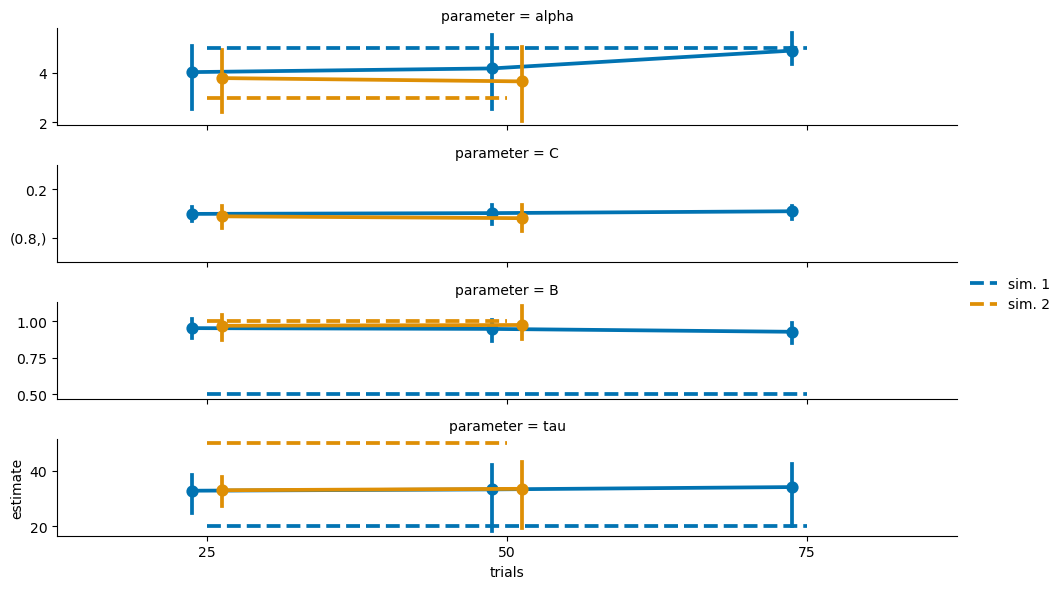

In [30]:
simulation_fit_metrics = pd.DataFrame()
for simulation_id in [0,1]:
    fit_summary_file = f"{results_directory}/simulation_summary_{simulation_id}"
    fit_summary_file  += f"_cd{context_depth}_nb{nback_depth}"
    fit_summary_file  += f".pkl"
    simulation_fit_metrics = pd.concat([simulation_fit_metrics, pd.read_pickle(fit_summary_file)])
simulation_fit_metrics["simulation"] = simulation_fit_metrics["simulation"].astype("category")
simulation_fit_metrics.reset_index(names="parameter", inplace=True)
simulation_fit_metrics["parameter"] = simulation_fit_metrics["parameter"].map({"alpha" : "alpha",
                                          "context_similarity_depth_1" : "C",
                                          "context_similarity_depth_2" : "C2",
                                          "repeat_bias_1_back" : "B",
                                          "timeconstant_within_session_A" : "tau"})

var_to_plot = "median"
palette="colorblind"   
g = sns.FacetGrid(simulation_fit_metrics, row="parameter", height=1.5, aspect=10/(1.5), sharey=False);
g.map_dataframe(sns.pointplot, x="trials", y=var_to_plot, errorbar=("pi",90), dodge=0.1, hue="simulation", palette=palette);
g.map_dataframe(sns.pointplot, x="trials", y="true",  linestyles="--", markers="", hue="simulation", palette=palette); #
g.add_legend()
for ax in g.axes[:,0]:
    ax.set_ylabel(None);

g.axes[-1,0].set_ylabel('estimate')